In [1]:
import report_utils
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, f1_score
import time
from tqdm import tqdm
import multiprocessing_notebook_helpers_2
import tensorflow as tf
import random 
import multiprocessing
import logging
from pathlib import Path
from IPython.display import clear_output

In [2]:
def set_random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

In [3]:
def get_files_and_names():
    # benchmark files checking
    all_files=[]
    all_files_name = []
    for root, dirs, files in os.walk("./data/"):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
                all_files_name.append(root.split("/")[-1] + "_" + file.replace(".", "_"))
    return all_files, all_files_name

def get_anomaly_data_and_names():
    all_files, all_files_name = get_files_and_names()
    # datasets with anomalies loading
    list_of_df = [pd.read_csv(file, 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True) for file in all_files if 'anomaly-free' not in file]
    list_of_names = [file for file in all_files_name if 'anomaly-free' not in file]
    return list_of_df, list_of_names

# benchmark files checking
all_files, all_names = get_files_and_names()
# datasets with anomalies loading
list_of_df, list_of_names = get_anomaly_data_and_names()

In [4]:
def driver_func(runnable_pipe_func, SAVE_FOLDER, cccc, nr_subsets, nr_percentage, family_descr, N_ESTIMATORS, N_CORES, list_of_df, random_seeds):
    with multiprocessing.Pool(N_CORES) as pool:
        results = [pool.apply_async(runnable_pipe_func, (SAVE_FOLDER, cccc, nr_subsets, nr_percentage, str(family_descr), f"task_model_{str(task_ind).rjust(3,'0')}",list_of_df, seed)) for task_ind, seed in zip(range(N_ESTIMATORS), random_seeds)]
        
        all_seeds = []
        count = 0
        for r in tqdm(results, f"task_model_{str(count).rjust(3,'0')}"):
            tmp_res = r.get()
            all_seeds.append(tmp_res)
            count+=1
    
    return all_seeds

In [5]:
for nr_percentage_ind, nr_percentage in enumerate([0.75, 0.70, 0.65, 0.60]):
    for N_ESTIMATORS in [11,13,15,17,19,21,23,25]:
        for cccc in [False]:
            for tmp_seed_number in range(1,50,1):
                print(tmp_seed_number)
                # N_ESTIMATORS = 61
                N_CORES = 11
                SAVE_FOLDER = f"./tmp_res_{N_ESTIMATORS}_{str(cccc)}_{nr_percentage_ind}"
                
                set_random(tmp_seed_number)
                Path(SAVE_FOLDER).mkdir(parents=True, exist_ok=True)

                log = logging.getLogger()
                for hdlr in log.handlers[:]:
                    log.removeHandler(hdlr)
                
                logging.basicConfig(level=logging.INFO, filename=f"{SAVE_FOLDER}/logs_info.log",
                                    format="CREATED_AT: %(asctime)s - MESSAGE: %(message)s")
                
                
                

                random_seeds = np.random.choice(9999, N_ESTIMATORS, replace=False).tolist()
                logging.info(f"'Params: N_ESTIMATORS: {N_ESTIMATORS} nr_percentage: {nr_percentage} general_seed: {str(tmp_seed_number)} other_seeds: [{str(random_seeds)}]'")
                
                res = driver_func(multiprocessing_notebook_helpers_2.run_pipeline_conv_ae, SAVE_FOLDER, cccc, 2, nr_percentage, str(tmp_seed_number), N_ESTIMATORS, N_CORES, list_of_df, random_seeds)
                
                time.sleep(10)
                
                df = report_utils.family_majority_voting(top_level_folder=SAVE_FOLDER, model_family=f"family_conv_ae_{str(tmp_seed_number)}")
                df = df[["predicted_anomaly_majority_voting"]]

                df_original = None
                if cccc:
                    df_original = pd.concat([tmp_df_orig for tmp_df_orig_ind, tmp_df_orig in enumerate(list_of_df) if tmp_df_orig_ind not in [4,6,8]],ignore_index=False)
                else:
                    df_original = pd.concat(list_of_df,ignore_index=False)
                df_original = df_original[["anomaly"]]

                final_df = pd.concat([df,df_original], ignore_index=False, axis=1)
                roc_number = roc_auc_score(final_df["anomaly"], final_df["predicted_anomaly_majority_voting"])
                F1 = f1_score(final_df["anomaly"], final_df["predicted_anomaly_majority_voting"])

                clear_output(wait=True)

                logging.info(f"'AUC: {roc_number} F1: {F1}")
                
                if roc_number>0.8310:
                    break

2


task_model_000:   0%|          | 0/11 [00:00<?, ?it/s]

In [9]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from IPython.display import clear_output
import os

class DFconstants():
    def __init__(self) -> None:
        self.parquet_suffix = 'parquet.gzip'
        self.NESTED_ROTATIONS = 'nested_rotations' 
        self.OTHER_INFO = 'other_info'
        self.PARTITION_PREFIX = 'partition_'
        self.SCALINGS = 'scalings'
        self.SCORES_AND_ANOMALIES = 'scores_and_anomalies'
    def __str__(self) -> str:
        return f"""parquet_suffix = '.parquet.gzip'
NESTED_ROTATIONS = 'nested_rotations' 
OTHER_INFO = 'other_info'
PARTITION_PREFIX = 'partition_'
SCALINGS = 'scalings'
SCORES_AND_ANOMALIES = 'scores_and_anomalies'"""
    def __repr__(self) -> str:
         return f"""parquet_suffix = '.parquet.gzip'
NESTED_ROTATIONS = 'nested_rotations' 
OTHER_INFO = 'other_info'
PARTITION_PREFIX = 'partition_'
SCALINGS = 'scalings'
SCORES_AND_ANOMALIES = 'scores_and_anomalies'"""

# def get_family_scores_and_anomalies(top_level_folder, model_family):

#     if top_level_folder is None:
#         raise ValueError(f"Missing top_level_folder={top_level_folder} is invalid")
#     elif top_level_folder == "":
#         raise ValueError(f"Missing top_level_folder={top_level_folder}")
    
#     while top_level_folder[-1] == "/":
#         top_level_folder = top_level_folder[:-1]
    
#     dfconstants = DFconstants()
    
#     model_tasks = os.listdir(f"{top_level_folder}/{model_family}")

#     model_task_dataframes = []
#     for model_task_ind, model_task in tqdm(enumerate(model_tasks), desc="Model"):
#         dataset_folders = os.listdir(f"{top_level_folder}/{model_family}/{model_task}")
#         df_datasets = []
#         for dataset in tqdm(dataset_folders, desc="Dataset"):
            
#         model_task_df = pd.concat(df_datasets, ignore_index=False)
#         model_task_df = model_task_df.rename(columns={"scores": f"scores_{model_task_ind}"})
#         model_task_df = model_task_df.rename(columns={"predicted_anomaly": f"predicted_anomaly_{model_task_ind}"})
#         model_task_dataframes.append(model_task_df)
#     final_df = pd.concat(model_task_dataframes, ignore_index=False,axis=1)
#     return final_df

In [20]:
dfconstants = DFconstants()
top_level_folder = "tmp_res_13_False_1"
for model_family in ["family_conv_ae_1", "family_conv_ae_2", "family_conv_ae_3"]:
    model_tasks = os.listdir(f"{top_level_folder}/{model_family}")
    for model_task in model_tasks:
        aaa = []
        dataset_folders = os.listdir(f"{top_level_folder}/{model_family}/{model_task}")
        for dataset_idx, dataset in enumerate(dataset_folders):
            partition_0 = f"{top_level_folder}/{model_family}/{model_task}/{dataset}/{dfconstants.PARTITION_PREFIX}0.{dfconstants.parquet_suffix}"
            partition_1 = f"{top_level_folder}/{model_family}/{model_task}/{dataset}/{dfconstants.PARTITION_PREFIX}1.{dfconstants.parquet_suffix}"
            nr = f"{top_level_folder}/{model_family}/{model_task}/{dataset}/{dfconstants.NESTED_ROTATIONS}.{dfconstants.parquet_suffix}"
            nr_df = pd.read_parquet(nr).columns.to_list()
            partition_0_df = pd.read_parquet(partition_0).columns.to_list()
            partition_1_df = pd.read_parquet(partition_1).columns.to_list()
            aaa.append((len(nr_df),len(partition_0_df),len(partition_1_df),model_family,model_task,dataset,nr_df))
        print(aaa)

[(5, 3, 2, 'family_conv_ae_1', 'model_name_task_model_000', 'data_name_000', ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Thermocouple', 'Voltage']), (7, 4, 3, 'family_conv_ae_1', 'model_name_task_model_000', 'data_name_001', ['Accelerometer1RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']), (4, 2, 2, 'family_conv_ae_1', 'model_name_task_model_000', 'data_name_002', ['Accelerometer2RMS', 'Pressure', 'Thermocouple', 'Voltage']), (5, 3, 2, 'family_conv_ae_1', 'model_name_task_model_000', 'data_name_003', ['Accelerometer1RMS', 'Current', 'Pressure', 'Voltage', 'Volume Flow RateRMS']), (5, 3, 2, 'family_conv_ae_1', 'model_name_task_model_000', 'data_name_004', ['Accelerometer1RMS', 'Accelerometer2RMS', 'Pressure', 'Temperature', 'Thermocouple']), (5, 3, 2, 'family_conv_ae_1', 'model_name_task_model_000', 'data_name_005', ['Accelerometer2RMS', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage']), (5, 3, 2, 'family_conv_ae_1', 'model_n

In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
X = np.array([-1, -1, -2, -1 ,-3, -2 ,1, 1 ,2, 1 ,3, 2])
pd.DataFrame(X)

,0
0,-1
1,-1
2,-2
3,-1
4,-3
5,-2
6,1
7,1
8,2
9,1


In [12]:
pca = PCA(n_components=2)
pca.fit(X)
N = pca.transform(X)
pd.DataFrame(N)

ValueError: Expected 2D array, got 1D array instead:
array=[-1. -1. -2. -1. -3. -2.  1.  1.  2.  1.  3.  2.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

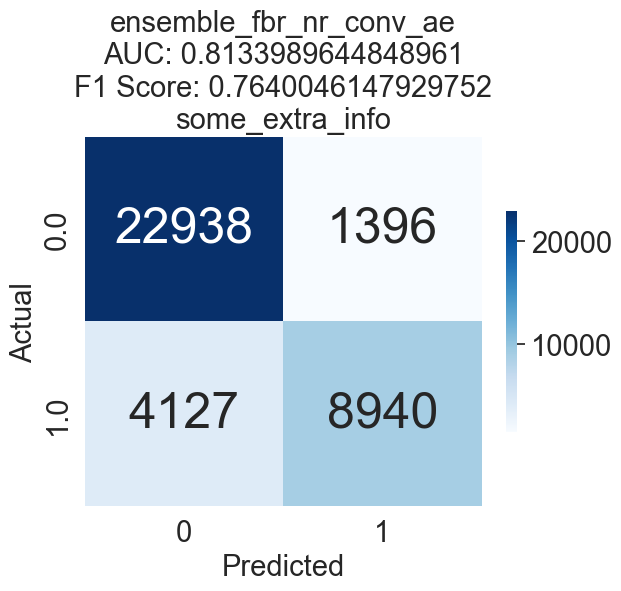

1

In [16]:
# report_utils.plot_single_confusion_matrix(final_df, "predicted_anomaly_majority_voting", "anomaly", "ensemble_fbr_nr_conv_ae", "some_extra_info", "./asdasd.png")